# Prosper Loan Dataset
## by Folami Justin Balogun

## Investigation Overview

> In this investigation, I will be exploring variables that will help Prosper Loan determine those most likely to complete their loans and those likely to have their loans charged off. The relationships between the loan status and the term, borrower apr, prosper score loan amount and income percentage used to service loan will be the main focus.
 
## Dataset Overview

> Provide a brief overview of the dataset to be presented here.
The dataset contains 113937 rows and 81 columns. I downloaded the data set from [here](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv). I worked with only observations where the loan status were either completed ot charged off.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan_data= pd.read_csv("prosperLoanData.csv")

In [3]:
# make a copy of the data
loan_df = loan_data.copy()

In [4]:
#alter column names
var=list(loan_df.columns)
var = [re.sub(r"(?<=[a-z])(?=[A-Z])", "_", x).lower() for x in var]
loan_df.columns = var

In [5]:
# select columns to work with
loan_df = loan_df[["listing_number",
"term",
"loan_status",
"borrower_apr",
"borrower_rate",
"prosper_score",
"listing_category (numeric)",
"occupation",
"employment_status",
"employment_status_duration",
"date_credit_pulled",
"debt_to_income_ratio",
"income_range",
"income_verifiable",
"stated_monthly_income",
"loan_original_amount",
"loan_origination_date",
"loan_origination_quarter",
"monthly_loan_payment",
"recommendations"]]

## Distribution of the loan status

> About 12,000 of the loans which constitutes about 10% of the total loans had their loans charged off while about 40,000 had completed their loan

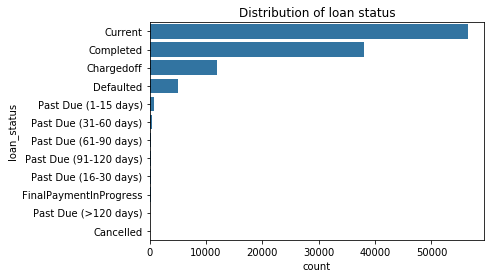

In [6]:
# explore loan_status

color=sb.color_palette()[0]

count = loan_df.loan_status.value_counts()
order = count.index
sb.countplot(data=loan_df, y="loan_status", color=color, order=order)
plt.title("Distribution of loan status");

In [7]:
# outliers 
outliers = (loan_df.stated_monthly_income > 50000) | (loan_df.monthly_loan_payment > 1500)

zero_income_and_loan_payment = (loan_df.stated_monthly_income == 0) | (loan_df.monthly_loan_payment ==0)


In [8]:
zero_income_and_loan_payment = (loan_df.stated_monthly_income == 0) | (loan_df.monthly_loan_payment ==0)


In [9]:
# remove the outliers
loan_df = loan_df.loc[-outliers & -zero_income_and_loan_payment,:]

In [10]:
inconsistency = (loan_df.prosper_score == 11)

# remove inconsistent data
loan_df = loan_df.loc[-inconsistency,:]

In [11]:
# create dataframe where loan_status is completed or charged off
completed_chargedoff = loan_df.query("(loan_status == 'Completed') | (loan_status == 'Chargedoff')")

## Relationship between loan status and term

> The initial exploration showed that chargedoff count was highest in those that took 36 months loans but a deeper dive showed that the probability of the loans being chargedoff was highest in those that took 60 month loans and lowest in 12 months long loans

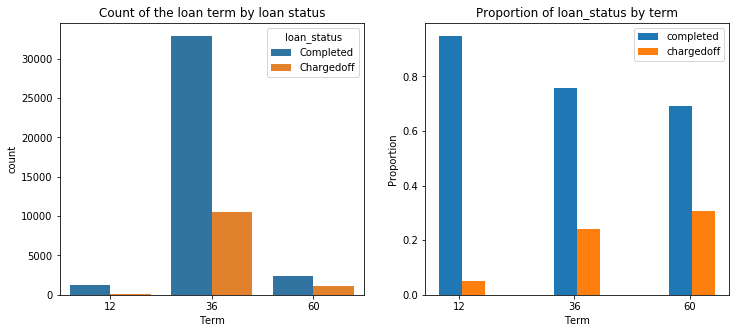

In [12]:
plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
sb.countplot(data = completed_chargedoff, x = "term", hue = 'loan_status');
plt.title("Count of the loan term by loan status")
plt.xlabel("Term")

plt.subplot(1,2,2)
#count number of borrowers present in each term
total_term = completed_chargedoff.groupby(['term']).count()['listing_number']
#count number of borrowers likely to complete the loan or have the loan chargedoff for each term
counts_term = completed_chargedoff.groupby(['term','loan_status']).count()['listing_number']

#calculate proportions for each age group
df_12 = counts_term[12]/total_term[12]
df_36 = counts_term[36]/total_term[36]
df_60 = counts_term[60]/total_term[60]


def plot(Title, y, x):
    x_axis = np.arange(len(label))    # the x locations for the groups
    plt.bar(x_axis +0.20, completed, width=0.2, label = 'completed')
    plt.bar(x_axis +0.20*2, chargedoff, width=0.2, label = 'chargedoff')
    plt.title(Title)  #title label
    plt.ylabel(y)    #y label
    plt.xlabel(x)    #x label
    location = x_axis + 0.55 / 2  
    plt.xticks(location,label)
    plt.legend(loc = 1)
    
label = [12,36,60]

#y-values
chargedoff = [df_12[0], df_36[0], df_60[0]]
completed = [df_12[1], df_36[1], df_60[1]]


plot('Proportion of loan_status by term','Proportion','Term')

## Correlation between the percentage of income used in servicing loans and the loan_status

> Also, I calculated a new variable (income_percentage_used_on_loan) from the monthly_loan_payment and the stated_monthly_income and checked how it correlated with the loan status. It showed that the chargedoff boxplot has a slightly higher median when compared to the completed. Its lower whisker is also much higher than that of the completed boxplot signifying that borrowers who end up having their loans chargedoff usually had a higher percentage of their income servicing the loan. It also shows that it is unlikely that a loan will be charged off if less than 0.1% of the monthly income is being used to service the debt.

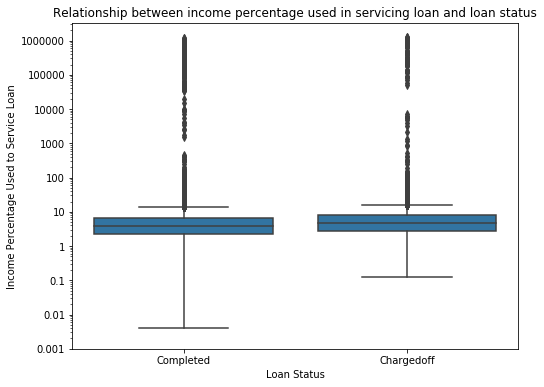

In [41]:
# calculate income_percentage_used_on_loan
completed_chargedoff["income_percentage_used_on_loan"] = (completed_chargedoff.monthly_loan_payment / completed_chargedoff.stated_monthly_income) * 100

plt.figure(figsize=[8,6])
# plot income_percentage_used_on_loan against loan status
ticks = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]
labels=["{}".format(v) for v in ticks]

sb.boxplot(data=completed_chargedoff,x="loan_status",y="income_percentage_used_on_loan",color=color)
plt.yscale("log")
plt.yticks(ticks,labels)
plt.ylabel("Income Percentage Used to Service Loan")
plt.xlabel("Loan Status")
plt.title("Relationship between income percentage used in servicing loan and loan status");
          

## Borrower APR and Prosper score versus Loan status
 
> A higher median score was associated with loan completion while a higher borrower_apr was associated with loan charge off

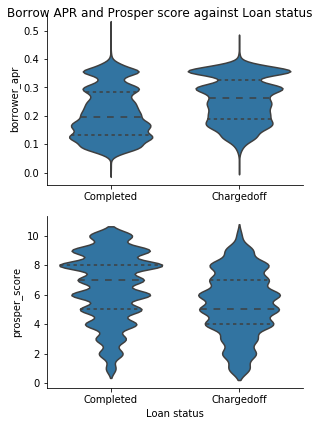

In [35]:
# plot matrix: categorical variables against other numeric variables
def violingrid(x, y, **kwargs):
    sb.violinplot(x=x, y=y, color=color, inner="quartile")

plt.figure(figsize = [10, 5])
g = sb.PairGrid(data = completed_chargedoff, y_vars = ["borrower_apr","prosper_score"], x_vars = ["loan_status"],
                size = 3, aspect = 1.5)
g.map(violingrid)
g.fig.suptitle('Borrow APR and Prosper score against Loan status')
plt.xlabel("Loan status");

## Multivarate relationship between Loan status, Borrower APR and Prosper_score

> Futhermore, I explored a multivarate relationship between the three variables. I observed that as borrower apr decreases for each loan status as prosper score increases. This decrease is at first very minimal up till a prosper score of 5 where the decrese is more drastic. 

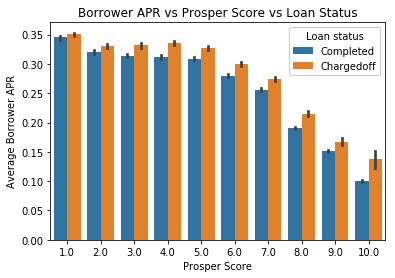

In [38]:
ax = sb.barplot(data=completed_chargedoff, x="prosper_score", y="borrower_apr", hue="loan_status", dodge=0.3)
ax.legend(loc = 1, framealpha=1, title="Loan status")
plt.ylabel("Average Borrower APR")
plt.xlabel("Prosper Score")
plt.title("Borrower APR vs Prosper Score vs Loan Status");

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_prosper_loan_dataset.ipynb --to slides --post serve --no-input --no-prompt